# Inspecting internals
This example assumes you've read `advanced.ipynb`, and covers:

   - Inspecting useful internal `TrainGenerator` & `DataGenerator` attributes
   - Inspecting train / validation interruptions

In [1]:
import deeptrain
deeptrain.util.misc.append_examples_dir_to_sys_path()  # for `from utils import`

from utils import make_autoencoder, init_session
from utils import AE_CONFIGS as C

### Configure & train

Discovered 48 files with matching format
48 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 48 files with matching format
................................................ finished, w/ 6144 total samples
Train initial data prepared
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 36 files with matching format
.................................... finished, w/ 4608 total sample

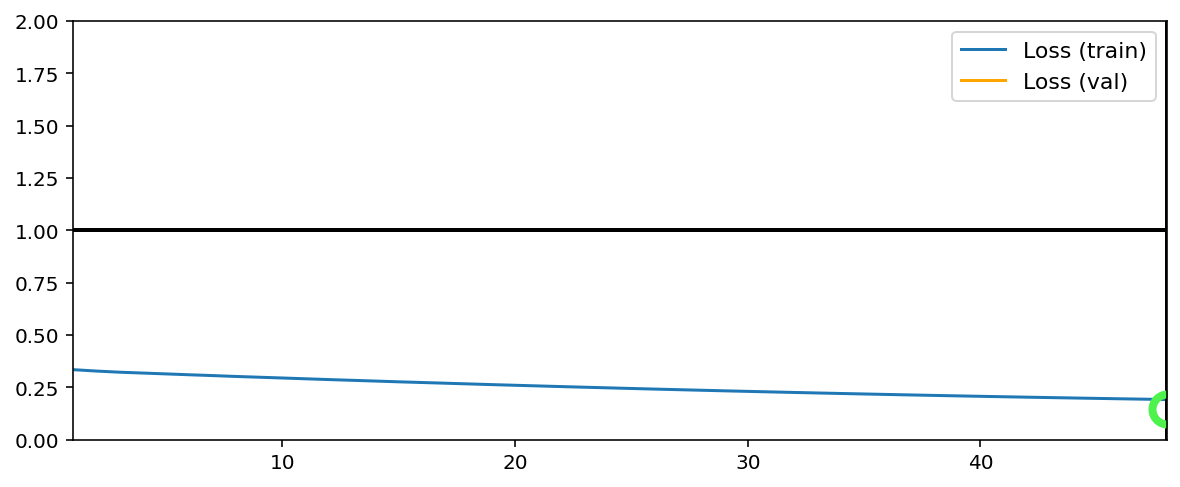

Training has concluded.


In [2]:
C['traingen']['epochs'] = 1  # don't need more
C['traingen']['iter_verbosity'] = 0  # don't need progress printing here
tg = init_session(C, make_autoencoder)
dg = tg.datagen
vdg = tg.val_datagen

tg.train()

### Arguments passed to TrainGenerator
Can see the arguments passed at `__init__`; this is saved in the state file, useful for seeing how exactly training was instantiated. Some objects are stored as string to allow pickling

In [3]:
from pprint import pprint
pprint(tg._passed_args)

{'best_models_dir': 'C:\\deeptrain\\examples\\dir\\models',
 'datagen': 'DataGenerator',
 'epochs': 1,
 'eval_fn': 'predict',
 'input_as_labels': True,
 'iter_verbosity': 0,
 'logs_dir': 'C:\\deeptrain\\examples\\dir\\logs',
 'max_is_best': False,
 'model': 'Functional',
 'model_configs': {'activation': ['relu', 'relu', 'relu', 'relu', 'relu'],
                   'batch_shape': (128, 28, 28, 1),
                   'filters': [6, 12, 2, 6, 12],
                   'input_dropout': 0.5,
                   'kernel_size': [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                   'loss': 'mse',
                   'metrics': None,
                   'optimizer': 'nadam',
                   'preout_dropout': 0.4,
                   'strides': [(2, 2), (2, 2), 1, 1, 1],
                   'up_sampling_2d': [None, None, None, (2, 2), (2, 2)]},
 'plot_configs': {'0': {'legend_kw': {'fontsize': 11}}},
 'val_datagen': 'DataGenerator'}


### Code used in training & initial attributes

   - `TrainGenerator`'s attributes at end of `__init__` are logged at end of `TrainGenerator.__init__`
     - savepath: `logdir/misc/init_state.json`
   - Source code used to run training (`__main__`) is also logged, assuming ran as a `.py` file (not IPython
     excerpt or Jupyter notebook)
     - savepath: `logdir/misc/init_script.txt`

In [4]:
import json
with open(tg.get_last_log('init_state'), 'r') as f:
    j = json.load(f)
    pprint(j)

{'_batches_fit': '0',
 '_batches_validated': '0',
 '_class_labels_cache': '[]',
 '_epoch': '0',
 '_eval_fn': 'fn',
 '_eval_fn_name': 'predict',
 '_fit_fn': 'fn',
 '_fit_fn_name': 'train_on_batch',
 '_fit_iters': '0',
 '_hist_vlines': '[]',
 '_history_fig': 'None',
 '_imports': "{'PIL': 1, 'LZ4F': 1}",
 '_inferred_batch_size': 'None',
 '_init_callbacks_called': 'True',
 '_labels': '[]',
 '_labels_cache': '[]',
 '_max_set_name_chars': '3',
 '_passed_args': 'dict',
 '_preds_cache': '[]',
 '_save_from_on_val_end': 'False',
 '_set_name': '1',
 '_set_name_cache': '[]',
 '_set_num': '1',
 '_sw_cache': '[]',
 '_temp_history_empty': "{'loss': []}",
 '_times_validated': '0',
 '_train_loop_done': 'False',
 '_train_new_batch_notified': 'False',
 '_train_postiter_processed': 'True',
 '_train_val_x_ticks': '[]',
 '_train_x_ticks': '[]',
 '_val_epoch': '0',
 '_val_hist_vlines': '[]',
 '_val_iters': '0',
 '_val_loop_done': 'False',
 '_val_max_set_name_chars': '2',
 '_val_new_batch_notified': 'False',


### Save directories

In [5]:
print("Best model directory:", tg.best_models_dir)
print("Checkpoint directory:", tg.logdir)
print("Model full name:", tg.model_name)

Best model directory: C:\deeptrain\examples\dir\models
Checkpoint directory: C:\deeptrain\examples\dir\logs\M5__model-nadam__min999.000
Model full name: M5__model-nadam__min.144


### Interrupts
Interrupts can be inspected by checking pertinent attributes manually<br>
`(_train_loop_done, _train_postiter_processed, _val_loop_done, _val_postiter_processed)`,<br>
or calling `interrupt_status()` which checks these and prints an appropriate message.

In [6]:
tg.interrupt_status()

No interrupts detected.

Flags checked:
	_train_loop_done          = False
	_train_postiter_processed = True
	_val_loop_done            = False
	_val_postiter_processed   = True


(False, False)

Interrupts can be manual (`KeyboardInterrupt`) or due to a `raise Exception`; either interrupts the flow of train/validation, so knowing at which point the fault occurred allows us to correct manually (e.g. execute portion of
code after an exception)

### Interrupt example

In [7]:
tg._train_loop_done = True
tg._val_loop_done = True
tg._val_postiter_processed = True

At this point `_on_val_end()` is called automatically, so if you're able to access such a state, it means the call didn't finish or was never initiated.

In [8]:
tg.interrupt_status()

Incomplete or not called `_on_val_end()` within `validate()`.
Interrupted: train[no], validation[yes].

Flags checked:
	_train_loop_done          = True
	_train_postiter_processed = True
	_val_loop_done            = True
	_val_postiter_processed   = True


(False, True)

### Example 2

In [9]:
tg._val_loop_done = False
tg._val_postiter_processed = False
tg.interrupt_status()

Interrupted during validation loop within `validate()`; incomplete or not called `_val_postiter_processing()`.
Interrupted: train[no], validation[yes].

Flags checked:
	_train_loop_done          = True
	_train_postiter_processed = True
	_val_loop_done            = False
	_val_postiter_processed   = False


(False, True)

In [10]:
help(tg.train)

Help on method train in module deeptrain.train_generator:

train() method of deeptrain.train_generator.TrainGenerator instance
    The train loop.
    
        - Fetches data from `get_data`
        - Fits data via `fin_fn`
        - Processes fit metrics in `_train_postiter_processing`
        - Stores metrics in `history`
        - Applies `'train:iter'`, `'train:batch'`, and `'train:epoch'`
          callbacks
        - Calls `validate` when appropriate
    
    **Interruption**:
    
        - *Safe*: during `get_data`, which can be called indefinitely
          without changing any attributes.
        - *Avoid*: during `_train_postiter_processing`, where `fit_fn` is
          applied and weights are updated - but metrics aren't stored, and
          `_train_postiter_processed=False`, restarting the loop without
          recording progress.
        - Best bet is during :meth:`validate`, as `get_data` may be too brief.



In [11]:
help(tg.validate)

Help on method validate in module deeptrain.train_generator:

validate(record_progress=True, clear_cache=True, restart=False, use_callbacks=True) method of deeptrain.train_generator.TrainGenerator instance
    Validation loop.
    
        - Fetches data from `get_data`
        - Applies function based on `_eval_fn_name`
        - Processes and caches metrics/predictions in
          `_val_postiter_processing`
        - Applies `'val:iter'`, `'val:batch'`, and `'val:epoch'` callbacks
        - Calls `_on_val_end` at end of validation to compute metrics
          and store them in `val_history`
        - Applies `'val_end'` and maybe `('val_end': 'train:epoch')` callbacks
        - If `restart`, calls :meth:`reset_validation`.
    
    **Arguments**:
        record_progress: bool
            If False, won't update `val_history`, `_val_iters`,
            `_batches_validated`.
        clear_cache: bool
            If False, won't call :meth:`clear_cache`; useful for keeping
            p

Interrupts can also be inspected by checking `temp_history`, `val_temp_history`, and cache attributes (e.g. `_preds_cache`); <br> cache attributes clear by default when `validate()` finishes.<br> Check `help(train)` and `help(validate)` for further interrupt guidelines.

### DataGenerator attributes

`set_nums_to_process` are the set nums remaining until end of epoch, which are then reset to `set_nums_original`. "Set" refers to data file to load.

In [12]:
# We can check which set numbers remain to be processed in epoch or validation:
print(dg.set_nums_to_process)
print(vdg.set_nums_to_process)
# We can arbitrarily append to or pop from the list to skip or repeat a batch

['42', '38', '34', '20', '25', '41', '14', '33', '30', '5', '19', '32', '11', '28', '46', '40', '27', '24', '2', '21', '9', '17', '1', '29', '43', '26', '23', '36', '7', '6', '48', '4', '39', '13', '12', '37', '45', '18', '44', '35', '10', '31', '22', '47', '8', '16', '15', '3']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36']


### Info function
Lastly, we can access most of the above via `info()`:

In [13]:
tg.info()

Epochs: 1/1
Train batches fit: 0/48 (in current epoch)
Val   batches fit: 0/36 (in current validation)
--------------------------------------------------------------------------------
Best model directory: C:\deeptrain\examples\dir\models
Checkpoint directory: C:\deeptrain\examples\dir\logs\M5__model-nadam__min999.000
Load path: None
Model full name: M5__model-nadam__min.144
--------------------------------------------------------------------------------
Interrupted during validation loop within `validate()`; incomplete or not called `_val_postiter_processing()`.
Interrupted: train[no], validation[yes].

Flags checked:
	_train_loop_done          = True
	_train_postiter_processed = True
	_val_loop_done            = False
	_val_postiter_processed   = False
